In [ ]:
# Copyright 2024 The AI Edge Torch Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

This Colab demonstrates how to convert a PyTorch [IS-Net](https://github.com/xuebinqin/DIS) model to a TensorFlow Lite model using the ai_edge_torch library. Validates the converted model with TFLite Interpreter.

# Prerequisites

First install all dependencies.

In [ ]:
!pip install -r https://raw.githubusercontent.com/google-ai-edge/ai-edge-torch/main/requirements.txt
!pip install ai-edge-torch
!pip install pillow requests matplotlib

Then download and read the test image.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   275  100   275    0     0    858      0 --:--:-- --:--:-- --:--:--   859
100  226k  100  226k    0     0   302k      0 --:--:-- --:--:-- --:--:-- 7946k


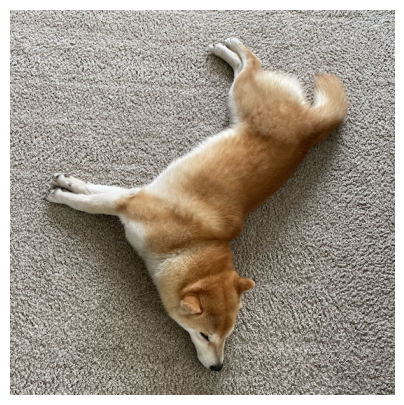

In [ ]:
!curl -H 'Accept: application/vnd.github.v3.raw'  -O   -L https://api.github.com/repos/google-ai-edge/ai-edge-torch/contents/test/image_segmentation/test_data/astrid_l_shaped.jpg

from matplotlib import pyplot as plt
from PIL import Image

IMAGE_PATH = '/content/astrid_l_shaped.jpg'
image = Image.open(IMAGE_PATH)
INPUT_IMAGE_HW = image.size
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(image)

# PyTorch model validation

Clone IS-Net DIS repo and download Pytorch model

In [ ]:
%cd /content
!rm -rf DIS sample_data

!git clone https://github.com/xuebinqin/DIS.git
%cd DIS/IS-Net/

!curl -o ./model.tar.gz -L https://www.kaggle.com/api/v1/models/paulruiz/dis/pyTorch/8-17-22/1/download
!tar -xvf 'model.tar.gz'

Build model

In [ ]:
import torch
from models import ISNetDIS


pytorch_model_filename = 'isnet-general-use.pth'
pt_model = ISNetDIS()
pt_model.load_state_dict(
    torch.load(pytorch_model_filename, map_location=torch.device('cpu'))
)
pt_model.eval();

Prepare inputs following the official Colab [demo](https://github.com/xuebinqin/DIS/blob/main/Colab_Demo.ipynb).

In [ ]:
from io import BytesIO
import numpy as np
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import normalize


MODEL_INPUT_HW = (1024, 1024)
image = io.imread(IMAGE_PATH)

# BHWC -> BCHW.
image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

# Resize to meet model input size requirements.
image_tensor = F.upsample(torch.unsqueeze(image_tensor, 0),
                          MODEL_INPUT_HW, mode='bilinear').type(torch.uint8)

# Scale [0, 255] -> [0, 1].
pt_image = torch.divide(image_tensor, 255.0)

# Normalize.
pt_image = normalize(pt_image, mean=[0.5, 0.5, 0.5], std=[1.0, 1.0, 1.0])

Get prediction and do post processing following the official Colab [demo](https://github.com/xuebinqin/DIS/blob/main/Colab_Demo.ipynb).

In [ ]:
# Get output with the most accurate prediction.
pt_result = pt_model(pt_image)[0][0]

# Recover the prediction spatial size to the orignal image size.
pt_result = F.upsample(pt_result, image.shape[:2],  mode='bilinear')
pt_result = torch.squeeze(pt_result, 0)

# Min-max normalization.
ma = torch.max(pt_result)
mi = torch.min(pt_result)
pt_result = (pt_result - mi) / (ma - mi)

# Scale [0, 1] -> [0, 255].
pt_result = pt_result * 255

# BCHW -> BHWC.
pt_result = pt_result.permute(1, 2, 0)

# Get numpy array.
pt_result = pt_result.cpu().data.numpy().astype(np.uint8)

Show the result segmentation mask.

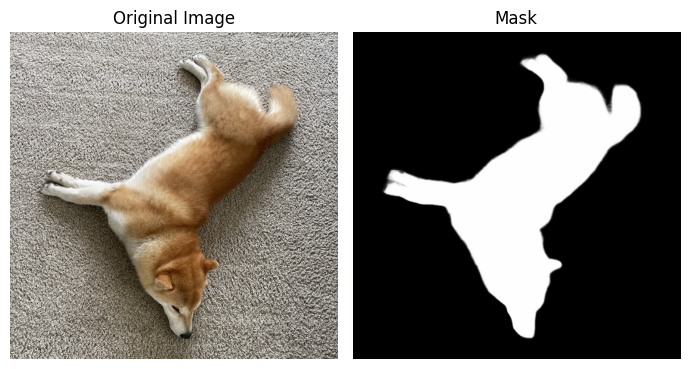

In [ ]:
from matplotlib import pyplot as plt


f, ax = plt.subplots(1, 2, figsize = (7,7))
ax[0].imshow(image)  # Original image.
ax[1].imshow(pt_result, cmap = 'gray')  # Segmentation mask.
ax[0].set_title('Original Image')
ax[1].set_title('Mask')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()
plt.show()

# Convert to TFLite

## Add model wrapper

The original IS-Net model generates 12 outputs. While the official PyTorch model demo provides guidance on selecting the correct output, obtaining the desired output from the converted TFLite model requires additional effort.

One of the methods is to download the tflite file after conversion step, open it with ModelExplorer and find which of the outputs is in the very bottom of the model graph and has the expected shape.

To simplify the process and eliminate this effort, let's use a wrapper around the PT model that channels only the best output. This approach ensures that the converted TFLite model has a single output.

Furthermore, we include some pre and post-processing steps, excluding min-max normalization as torch.min and torch.max are not supported yet.

In [ ]:
import torch
from torch import nn
from torchvision.transforms.functional import normalize


class ImageSegmentationModelWrapper(nn.Module):

  RESCALING_FACTOR = 255.0
  MEAN = 0.5
  STD = 1.0

  def __init__(self, pt_model):
    super().__init__()
    self.model = pt_model

  def forward(self, image: torch.Tensor):
    # BHWC -> BCHW.
    image = image.permute(0, 3, 1, 2)

    # Rescale [0, 255] -> [0, 1].
    image = image / self.RESCALING_FACTOR

    # Normalize.
    image = (image - self.MEAN) / self.STD

    # Get result.
    result = self.model(image)[0][0]

    # BHWC -> BCHW.
    result = result.permute(0, 2, 3, 1)

    return result


wrapped_pt_model = ImageSegmentationModelWrapper(pt_model).eval()

## Convert to TFLite

Provide sample arguments -- result TFLite model will expect input of this size -- and convert the model.

In [ ]:
import ai_edge_torch


sample_args = (torch.rand((1, *MODEL_INPUT_HW, 3)),)
edge_model = ai_edge_torch.convert(wrapped_pt_model, sample_args)

# Validate converted model with TFLite Interpreter

Validation utility.

In [ ]:
def get_processed_isnet_result(model_output, original_image_hw):
    # Min-max normalization.
    output_min = model_output.min()
    output_max = model_output.max()
    result = (model_output - output_min) / (output_max - output_min)

    # Scale [0, 1] -> [0, 255].
    result = (result * 255).astype(np.uint8)

    # Restore original image size.
    result = Image.fromarray(result.squeeze(), "L")
    return result.resize(original_image_hw, Image.Resampling.BILINEAR)

Prepare input image. Since we put all preprocessing into the model, only resizing and type cast is left.

In [ ]:
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np


image = Image.open(IMAGE_PATH)
np_image = np.array(image.resize(MODEL_INPUT_HW, Image.Resampling.BILINEAR))
np_image = np.expand_dims(np_image, axis=0).astype(np.float32)

Get prediction and do post processing.

In [ ]:
edge_model_output = edge_model(np_image)

tfl_result = get_processed_isnet_result(edge_model_output, INPUT_IMAGE_HW)

Plot all results for comparison.

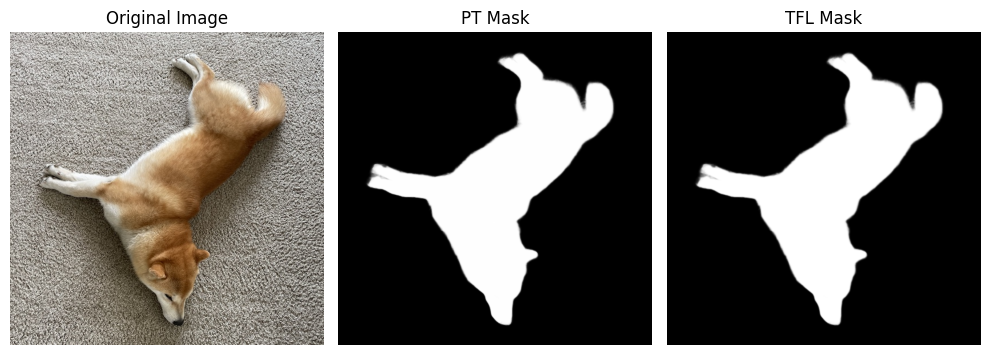

In [ ]:
from matplotlib import pyplot as plt


f, ax = plt.subplots(1, 3, figsize = (10,10))
ax[0].imshow(image)  # Original image.
ax[1].imshow(pt_result, cmap = 'gray')  # PT segmentation mask.
ax[2].imshow(tfl_result, cmap = 'gray')  # TFL segmentation mask.
ax[0].set_title('Original Image')
ax[1].set_title('PT Mask')
ax[2].set_title('TFL Mask')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.tight_layout()
plt.show()

Same as for the original PyTorch model!

# Post Training and Dynamic-Range Quantization with TFLite

Perform Dynamic-Range quantization with TFLite Converter by passing quantization flags in _ai_edge_converter_flags parameter. More details on post-training quantization can be found [here](https://www.tensorflow.org/lite/performance/post_training_quantization).

In [ ]:
import tensorflow as tf


tfl_converter_flags={
    "optimizations": [tf.lite.Optimize.DEFAULT]
}
tfl_drq_model = ai_edge_torch.convert(
    wrapped_pt_model,
    sample_args,
    _ai_edge_converter_flags=tfl_converter_flags
)

Validate the output.

In [ ]:
tfl_drq_output = tfl_drq_model(np_image)

tfl_drq_result = get_processed_isnet_result(tfl_drq_output, INPUT_IMAGE_HW)

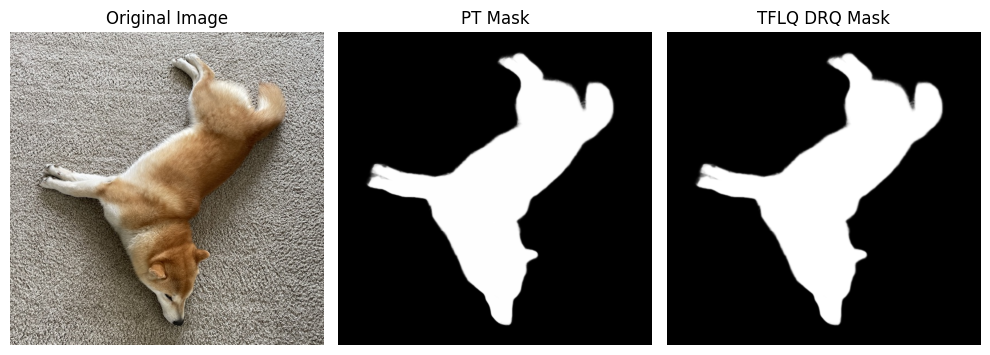

In [ ]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(1, 3, figsize = (10,10))
ax[0].imshow(image)  # Original image.
ax[1].imshow(pt_result, cmap = 'gray')  # PT segmentation mask.
ax[2].imshow(tfl_drq_result, cmap = 'gray')  # TFL segmentation mask.
ax[0].set_title('Original Image')
ax[1].set_title('PT Mask')
ax[2].set_title('TFLQ DRQ Mask')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.tight_layout()
plt.show()

# Post Training and Dynamic-Range Quantization with PT2E

Perform Dynamic-Range quantization with PT2E and PT2EQuantizer

PT2E is a framework-level quantization feature available in PyTorch 2.0. For more details see [PyTorch tutorial](https://pytorch.org/tutorials/prototype/quantization_in_pytorch_2_0_export_tutorial.html).

PT2EQuantizer is ai-edge-torch backend specific and is configured to quantize models to leverage the quantized operators/kernels offered by the TFLite Runtime.

In [ ]:
from ai_edge_torch.quantize.pt2e_quantizer import get_symmetric_quantization_config
from ai_edge_torch.quantize.pt2e_quantizer import PT2EQuantizer
from ai_edge_torch.quantize.quant_config import QuantConfig

from torch.ao.quantization.quantize_pt2e import prepare_pt2e, convert_pt2e
from torch._export import capture_pre_autograd_graph


pt2e_quantizer = PT2EQuantizer().set_global(
    get_symmetric_quantization_config(is_per_channel=True, is_dynamic=True)
)

# Following are the required steps recommended in the PT2E quantization
# workflow.
autograd_torch_model = capture_pre_autograd_graph(wrapped_pt_model, sample_args)
# 1. Prepare for quantization.
pt2e_torch_model = prepare_pt2e(autograd_torch_model, pt2e_quantizer)
# 2. Run the prepared model with sample input data to ensure that internal
# observers are populated with correct values.
pt2e_torch_model(*sample_args)
# 3. Finally, convert (quantize) the prepared model.
pt2e_torch_model = convert_pt2e(pt2e_torch_model, fold_quantize=False)

pt2e_drq_model = ai_edge_torch.convert(
    pt2e_torch_model,
    sample_args,
    quant_config=QuantConfig(pt2e_quantizer=pt2e_quantizer)
)

In [ ]:
pt2e_drq_output = pt2e_drq_model(np_image)

pt2e_drq_result = get_processed_isnet_result(pt2e_drq_output, INPUT_IMAGE_HW)

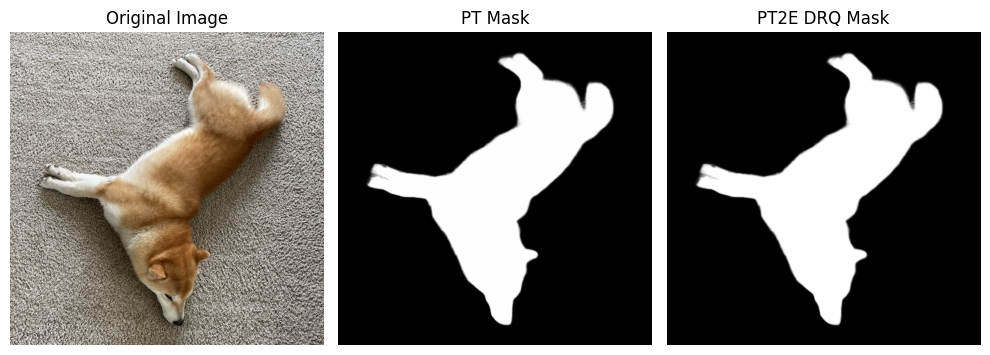

In [ ]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(1, 3, figsize = (10,10))
ax[0].imshow(image)  # Original image.
ax[1].imshow(pt_result, cmap = 'gray')  # PT segmentation mask.
ax[2].imshow(pt2e_drq_result, cmap = 'gray')  # TFL segmentation mask.
ax[0].set_title('Original Image')
ax[1].set_title('PT Mask')
ax[2].set_title('PT2E DRQ Mask')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.tight_layout()
plt.show()

# Download converted models

In [ ]:
from google.colab import files

tfl_filename = "isnet.tflite"
edge_model.export(tfl_filename)

files.download(tfl_filename)

In [ ]:
tfl_drq_filename = 'isnet_tfl_drq.tflite'
tfl_drq_model.export(tfl_drq_filename)

files.download(tfl_drq_filename)

In [ ]:
pt2e_drq_filename = 'isnet_pt2e_drq.tflite'
pt2e_drq_model.export(pt2e_drq_filename)

files.download(pt2e_drq_filename)